In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.metrics import adjusted_rand_score

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import diffmodel
import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [57]:
import importlib 
importlib.reload(model)
importlib.reload(diffmodel)

<module 'diffmodel' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/diffmodel.py'>

In [3]:
dir = '../data/real/Xichen/small_ver'

counts_rna = sp.load_npz(os.path.join(dir, 'GxC1_small.npz'))
counts_atac = sp.load_npz(os.path.join(dir, 'RxC2_small.npz')).astype(np.float32)
A = sp.load_npz(os.path.join(dir, 'GxR_small.npz'))
subsample = 1

counts_rna = np.array(counts_rna.todense().T)
counts_atac = np.array(counts_atac.todense().T)
counts_rna = counts_rna[::subsample,:]
counts_atac = counts_atac[::subsample,:]
A = np.array(A.todense())

counts = {"rna":[counts_rna, None], "atac": [None, counts_atac], "gact": A}

label_rna = pd.read_csv("../data/real/Xichen/meta_rna.csv", index_col=0)["cell_type"].values.squeeze()
label_atac = pd.read_csv("../data/real/Xichen/meta_atac.csv", index_col=0)["cell_type"].values.squeeze()

In [98]:
dir = '../data/simulated/'

path = '2b4c_sigma0.1_b1_1/'
# path = '2b5c_ziqi1/'

counts_rna1 = pd.read_csv(os.path.join(dir + path, 'GxC1.txt'), sep = "\t", header = None).values.T
counts_rna2 = pd.read_csv(os.path.join(dir + path, 'GxC2.txt'), sep = "\t", header = None).values.T
counts_atac1 = pd.read_csv(os.path.join(dir + path, 'RxC1.txt'), sep = "\t", header = None).values.T
counts_atac2 = pd.read_csv(os.path.join(dir + path, 'RxC2.txt'), sep = "\t", header = None).values.T
A = pd.read_csv(os.path.join(dir + path, 'region2gene.txt'), sep = "\t", header = None).values.T

counts_rna1 = np.array(counts_rna1)
counts_rna2 = np.array(counts_rna2)
counts_atac1 = np.array(counts_atac1)
counts_atac2 = np.array(counts_atac2)
A = np.array(A)


label_rna = pd.read_csv(os.path.join(dir + path, "cell_label1.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir + path, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

# counts_atac = counts_atac[np.where(label_atac != 1)[0],:]
# label_atac = label_atac[np.where(label_atac != 1)[0]]

counts = {"rna":[counts_rna1], "atac": [counts_atac1], "gact": A}
# counts = {"rna":[counts_rna1, counts_rna2], "atac": [None, None], "gact": A}
# counts = {"rna":[counts_rna1, None], "atac": [counts_atac1, counts_atac2], "gact": A}
counts = {"rna":[counts_rna1, counts_rna2], "atac": [counts_atac1, counts_atac2], "gact": A}

In [92]:
counts_rna = np.concatenate((counts_rna1, counts_rna2), axis = 0)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(counts_rna)


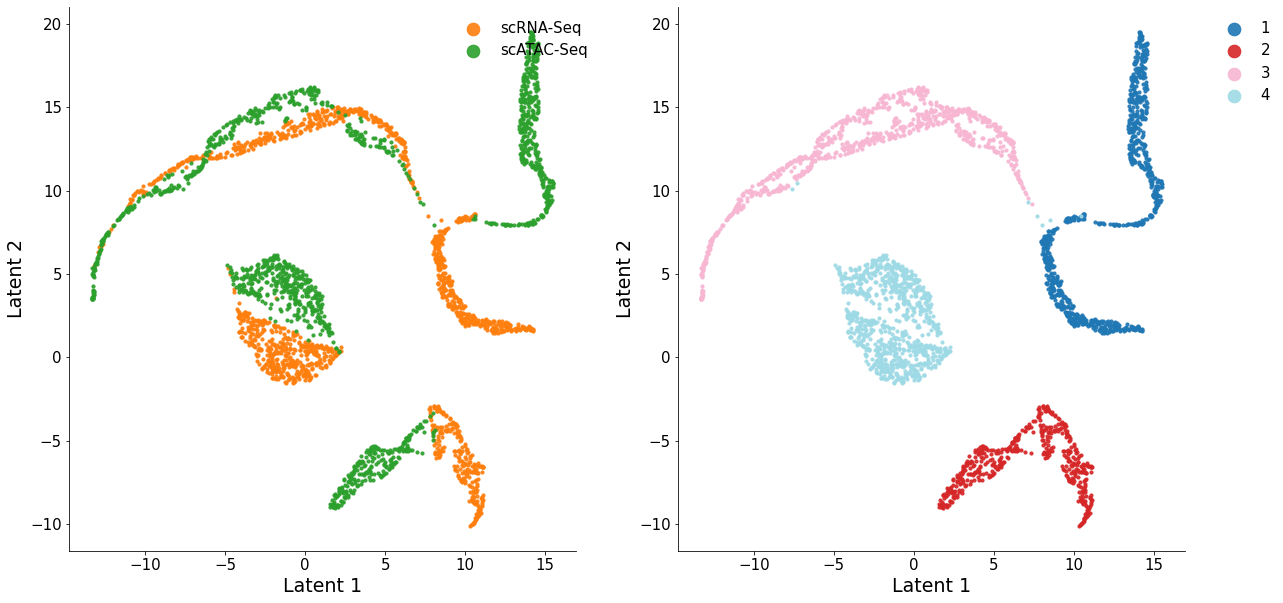

In [88]:
utils.plot_latent(z[:counts_rna1.shape[0],:], z[counts_rna1.shape[0]:,:], 
                  label_rna, label_atac, mode= "hybrid", save = None)

In [99]:
# train model
alpha = [1000, 1000, 100, 100, 1, 0.5, 0.5, 0.1]

Ns = [4,4]
K = 4
N_feat = Ns[0] + 1

model1 = model.cfrm(counts, Ns = Ns, K = K, N_feat = N_feat, batch_size = 0.3, interval=100, lr=1e-3, alpha =alpha, seed = 1).to(device)

model1.train_func(T = 10000)
# model1.load_state_dict(torch.load(f'../check_points/real_5.pt'))

Epoch 100, Validating Loss: -105.8659
	 loss 1: 31.78780
	 loss 2: 53.92513
	 loss 3: -96.28989
	 loss 4: -97.26996
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: -0.00000
	 loss 8: 1.98104
Epoch 200, Validating Loss: -110.6322
	 loss 1: 31.79116
	 loss 2: 53.94701
	 loss 3: -99.75363
	 loss 4: -98.57889
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: -0.00000
	 loss 8: 1.96219
Epoch 300, Validating Loss: -111.5194
	 loss 1: 31.80804
	 loss 2: 53.94004
	 loss 3: -99.99500
	 loss 4: -99.19839
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: -0.00000
	 loss 8: 1.92595
Epoch 400, Validating Loss: -111.8600
	 loss 1: 31.79077
	 loss 2: 53.93045
	 loss 3: -99.99936
	 loss 4: -99.46312
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: -0.00000
	 loss 8: 1.88128
Epoch 500, Validating Loss: -112.0740
	 loss 1: 31.78353
	 loss 2: 53.88910
	 loss 3: -99.99966
	 loss 4: -99.57541
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: -0.00000
	 loss 8: 1.82843
Epoch 600, Validating Loss: -112.3378
	 loss 1: 31.7269

Epoch 4500, Validating Loss: -141.8452
	 loss 1: 20.60253
	 loss 2: 34.55156
	 loss 3: -99.99908
	 loss 4: -98.25546
	 loss 5: 0.00000
	 loss 6: -0.49698
	 loss 7: -0.51722
	 loss 8: 2.26941
Epoch 4600, Validating Loss: -141.8552
	 loss 1: 20.59735
	 loss 2: 34.54819
	 loss 3: -99.99908
	 loss 4: -98.25362
	 loss 5: 0.00000
	 loss 6: -0.49721
	 loss 7: -0.51848
	 loss 8: 2.26765
Epoch 4700, Validating Loss: -141.8654
	 loss 1: 20.60147
	 loss 2: 34.54594
	 loss 3: -99.99895
	 loss 4: -98.26130
	 loss 5: 0.00000
	 loss 6: -0.49743
	 loss 7: -0.51968
	 loss 8: 2.26452
Epoch 4800, Validating Loss: -141.8848
	 loss 1: 20.60096
	 loss 2: 34.54456
	 loss 3: -99.99911
	 loss 4: -98.27200
	 loss 5: 0.00000
	 loss 6: -0.49761
	 loss 7: -0.52109
	 loss 8: 2.25949
Epoch 4900, Validating Loss: -141.8913
	 loss 1: 20.59932
	 loss 2: 34.54650
	 loss 3: -99.99909
	 loss 4: -98.27531
	 loss 5: 0.00000
	 loss 6: -0.49777
	 loss 7: -0.52254
	 loss 8: 2.25755
Epoch 5000, Validating Loss: -141.9063
	 loss

Epoch 8800, Validating Loss: -142.2113
	 loss 1: 20.59353
	 loss 2: 34.52267
	 loss 3: -99.99876
	 loss 4: -98.42318
	 loss 5: 0.00000
	 loss 6: -0.49931
	 loss 7: -0.59640
	 loss 8: 2.19015
Epoch 8900, Validating Loss: -142.2212
	 loss 1: 20.59734
	 loss 2: 34.52283
	 loss 3: -99.99863
	 loss 4: -98.43069
	 loss 5: 0.00000
	 loss 6: -0.49932
	 loss 7: -0.59898
	 loss 8: 2.18628
Epoch 9000, Validating Loss: -142.2229
	 loss 1: 20.59619
	 loss 2: 34.51966
	 loss 3: -99.99859
	 loss 4: -98.42667
	 loss 5: 0.00000
	 loss 6: -0.49933
	 loss 7: -0.60154
	 loss 8: 2.18739
Epoch 9100, Validating Loss: -142.2404
	 loss 1: 20.59248
	 loss 2: 34.51720
	 loss 3: -99.99841
	 loss 4: -98.43214
	 loss 5: 0.00000
	 loss 6: -0.49933
	 loss 7: -0.60383
	 loss 8: 2.18362
Epoch 9200, Validating Loss: -142.2378
	 loss 1: 20.59596
	 loss 2: 34.52474
	 loss 3: -99.99860
	 loss 4: -98.43541
	 loss 5: 0.00000
	 loss 6: -0.49933
	 loss 7: -0.60664
	 loss 8: 2.18151
Epoch 9300, Validating Loss: -142.2571
	 loss

In [101]:
z_rna = model1.softmax(model1.Cs[0]).cpu().detach().numpy()
z_atac = model1.softmax(model1.Cs[1]).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

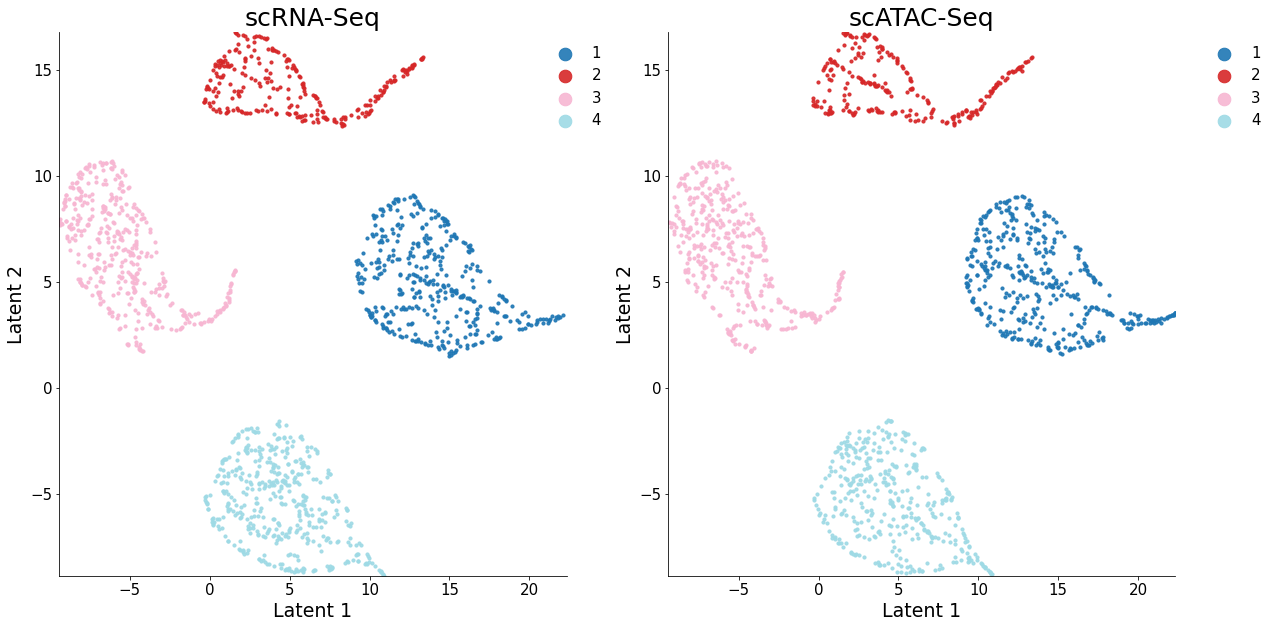

In [96]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

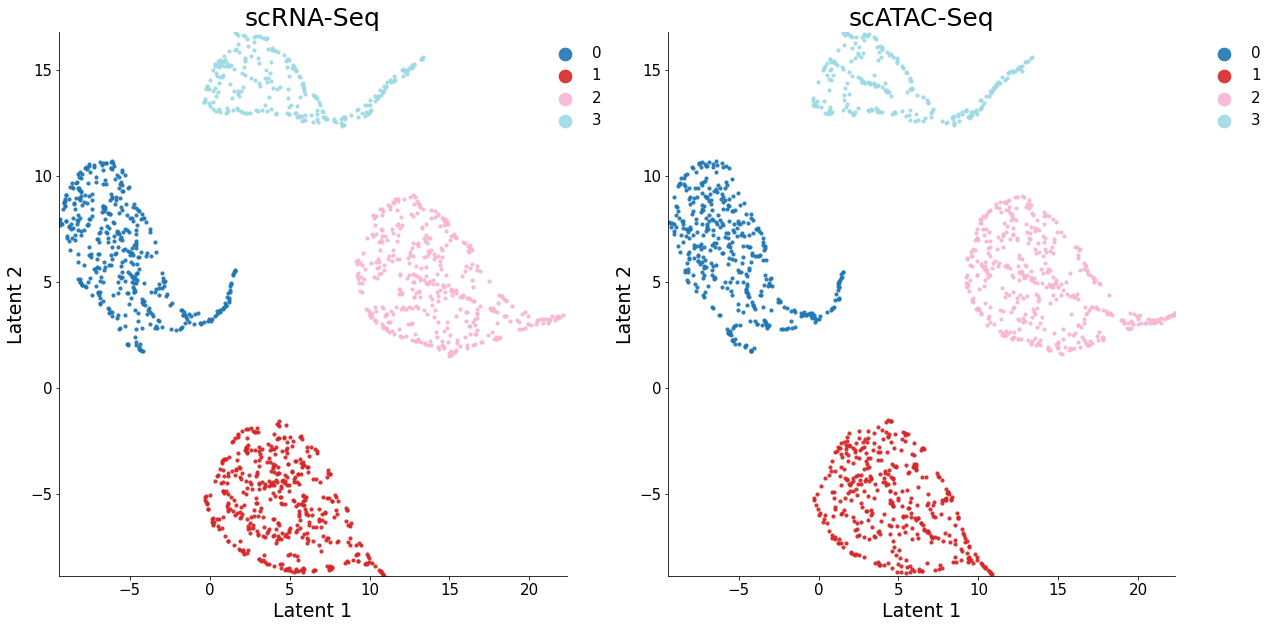

In [97]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

In [9]:
# # train model
# alpha = [1000, 1000, 100, 100, 1, 0.5, 0.5, 0.0, 0.1]

# N1 = 4
# N2 = 4
# K = 4
# N_feat = N1 + 1
# model2 = diffmodel.cfrm_diff2(counts, N1 = N1, N2 = N2, K = K, N_feat = N_feat, batch_size = 0.3, interval=100, lr=1e-3, 
#                             alpha =alpha, seed = 0, learn_gact = False).to(device)

# model2.train_func(T = 10000)
# # model1.load_state_dict(torch.load(f'../check_points/real_5.pt'))

In [35]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

AttributeError: 'cfrm' object has no attribute 'C_1'

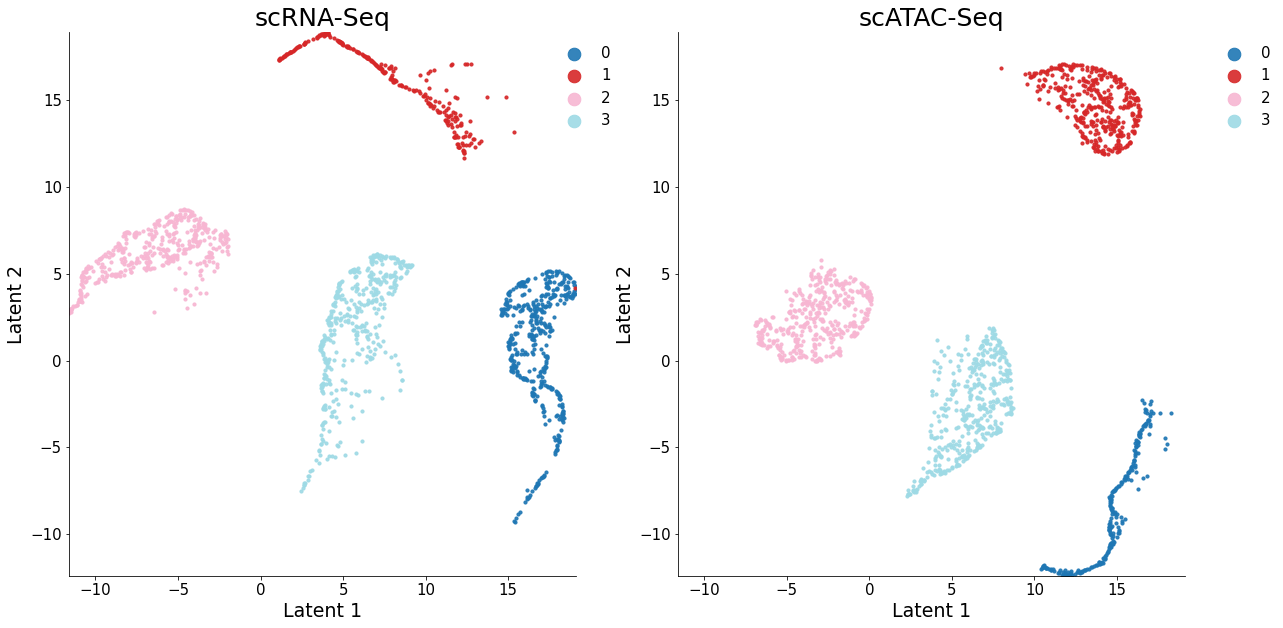

In [21]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

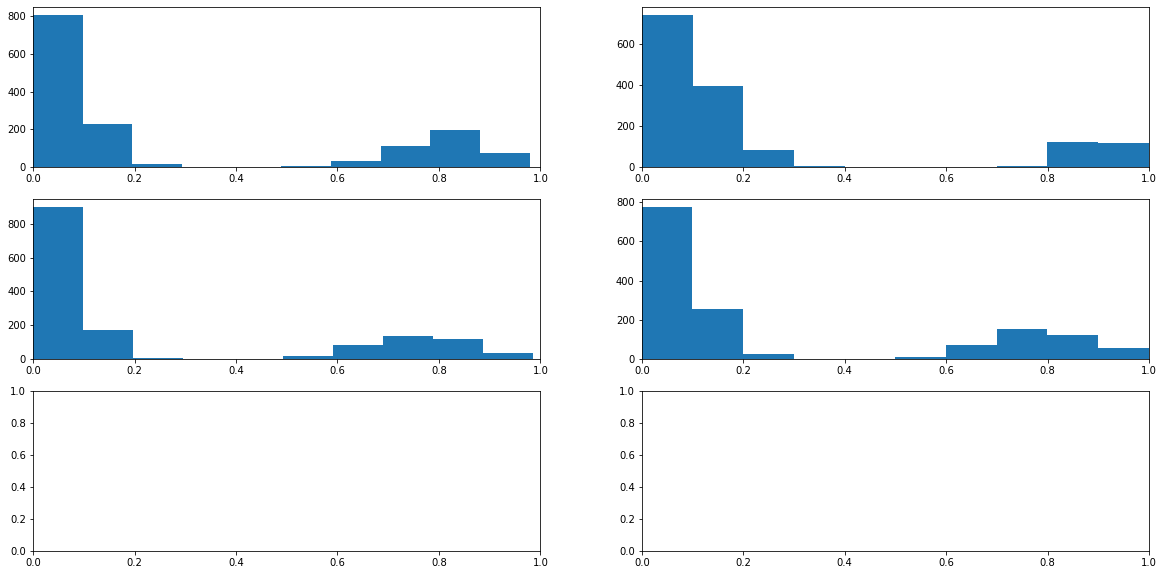

In [13]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_atac[:,0])
_ = axs[0,1].hist(z_atac[:,1])
_ = axs[1,0].hist(z_atac[:,2])
_ = axs[1,1].hist(z_atac[:,3])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])

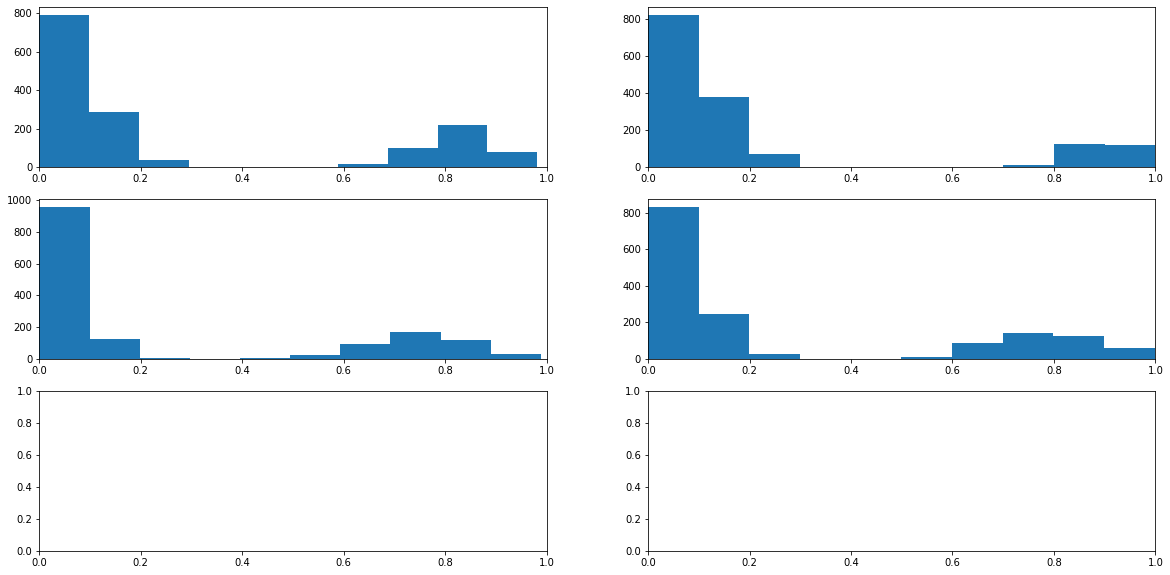

In [14]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_rna[:,0])
_ = axs[0,1].hist(z_rna[:,1])
_ = axs[1,0].hist(z_rna[:,2])
_ = axs[1,1].hist(z_rna[:,3])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])


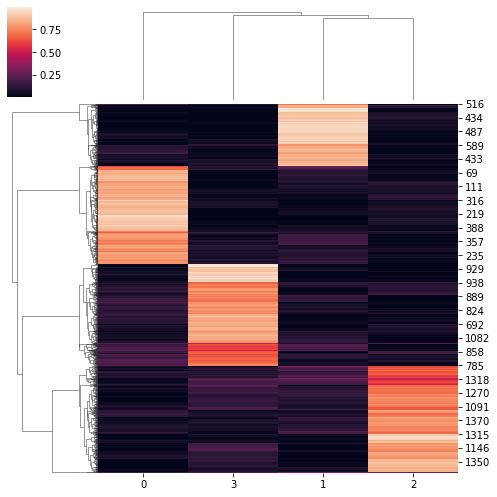

In [15]:
g = sns.clustermap(z_rna, figsize = (7,7))

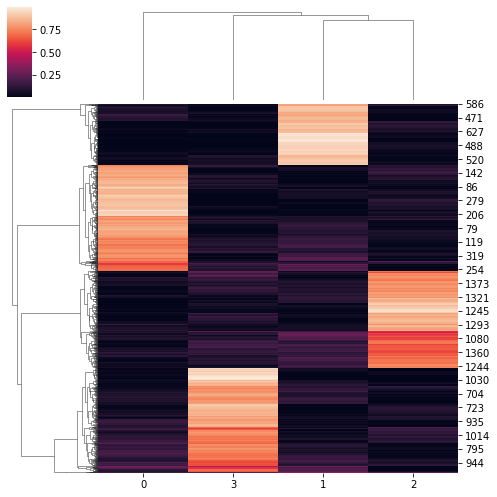

In [16]:
g = sns.clustermap(z_atac, figsize = (7,7))

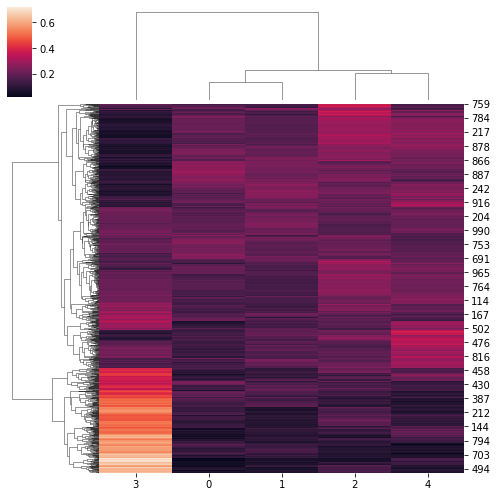

In [26]:
z_g = model1.softmax(model1.C_g).cpu().detach().numpy()
z_r = model1.softmax(model1.C_r).cpu().detach().numpy()
_ = sns.clustermap(z_g, figsize = (7,7))

/storage/home/hhive1/zzhang834/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


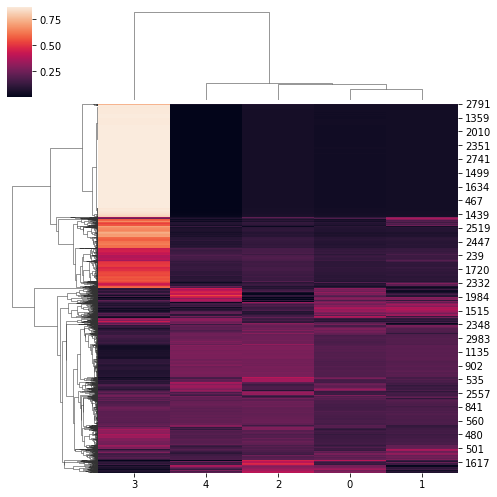

In [27]:
_ = sns.clustermap(z_r, figsize = (7,7))

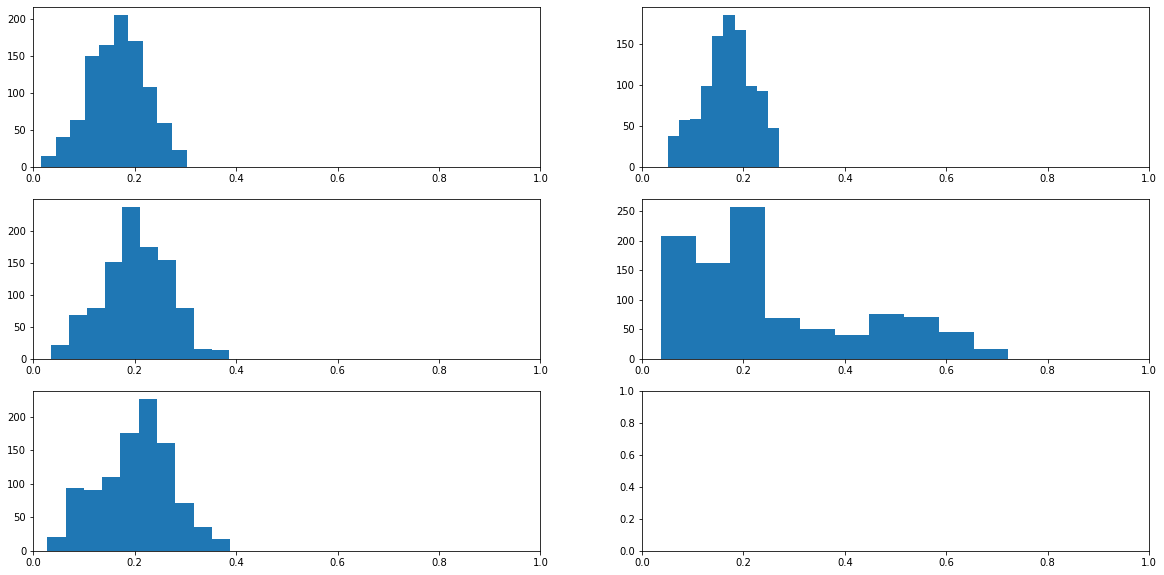

In [28]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_g[:,0])
_ = axs[0,1].hist(z_g[:,1])
_ = axs[1,0].hist(z_g[:,2])
_ = axs[1,1].hist(z_g[:,3])
_ = axs[2,0].hist(z_g[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

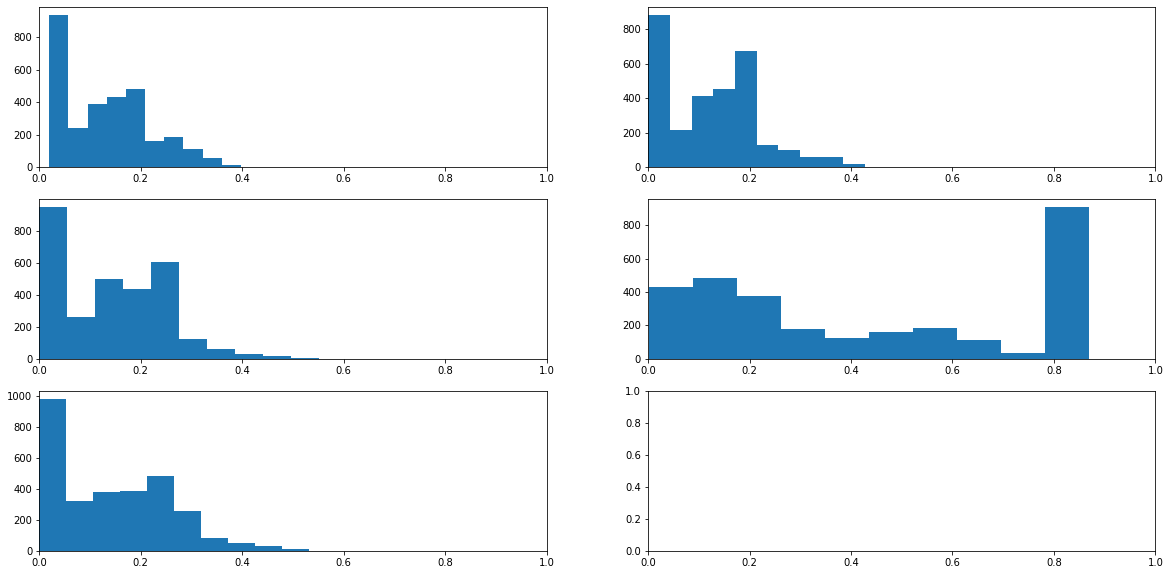

In [29]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_r[:,0])
_ = axs[0,1].hist(z_r[:,1])
_ = axs[1,0].hist(z_r[:,2])
_ = axs[1,1].hist(z_r[:,3])
_ = axs[2,0].hist(z_r[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

In [30]:
adjusted_rand_score(labels_pred = np.concatenate((max_rna, max_atac), axis = 0), labels_true = np.concatenate((label_rna, label_atac), axis = 0))

0.7408771194518943

In [33]:
model1.A_r.abs() > 1e-3

tensor([[False,  True, False, False,  True],
        [ True, False, False, False, False],
        [False, False, False,  True,  True],
        [False, False,  True,  True, False]], device='cuda:0')

In [81]:
# train model
alpha = [1000, 1000, 100, 100, 1, 0, 0, 0]
model1 = cfrm_diff(counts, N1 = 8, N2 = 8, K = 8, batch_size = 0.1, interval=100, lr=1e-3, 
                            alpha =alpha, seed = 0, learn_gact = False).to(device)

model1.train_func(T = 10000)
# model1.load_state_dict(torch.load(f'../check_points/real_5.pt'))

Epoch 100, Validating Loss: -96.6536
	 loss 1: 8.17839
	 loss 2: 80.54482
	 loss 3: -89.36578
	 loss 4: -96.01104
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 200, Validating Loss: -106.0157
	 loss 1: 8.16446
	 loss 2: 80.51707
	 loss 3: -97.83003
	 loss 4: -96.86717
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 300, Validating Loss: -108.6018
	 loss 1: 8.16488
	 loss 2: 80.51913
	 loss 3: -99.70160
	 loss 4: -97.58425
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 400, Validating Loss: -109.4632
	 loss 1: 8.16446
	 loss 2: 80.51814
	 loss 3: -99.97143
	 loss 4: -98.17435
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 500, Validating Loss: -109.9530
	 loss 1: 8.16374
	 loss 2: 80.51012
	 loss 3: -99.99815
	 loss 4: -98.62873
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 600, Validating Loss: -110.2932
	 loss 1: 8.16177
	 loss 2: 

Epoch 4500, Validating Loss: -118.4113
	 loss 1: 7.66041
	 loss 2: 73.71529
	 loss 3: -99.99992
	 loss 4: -99.78712
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4600, Validating Loss: -118.4243
	 loss 1: 7.65300
	 loss 2: 73.70805
	 loss 3: -99.99988
	 loss 4: -99.78550
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4700, Validating Loss: -118.4497
	 loss 1: 7.64062
	 loss 2: 73.69273
	 loss 3: -99.99979
	 loss 4: -99.78323
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4800, Validating Loss: -118.4677
	 loss 1: 7.63100
	 loss 2: 73.68479
	 loss 3: -99.99982
	 loss 4: -99.78364
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4900, Validating Loss: -118.4753
	 loss 1: 7.62668
	 loss 2: 73.67751
	 loss 3: -99.99987
	 loss 4: -99.77964
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 5000, Validating Loss: -118.4871
	 loss 1: 7.61530
	 l

Epoch 8900, Validating Loss: -118.7477
	 loss 1: 7.51150
	 loss 2: 73.38924
	 loss 3: -99.99982
	 loss 4: -99.64864
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9000, Validating Loss: -118.7558
	 loss 1: 7.51190
	 loss 2: 73.37922
	 loss 3: -99.99989
	 loss 4: -99.64700
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9100, Validating Loss: -118.7721
	 loss 1: 7.51113
	 loss 2: 73.36757
	 loss 3: -99.99977
	 loss 4: -99.65103
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9200, Validating Loss: -118.7670
	 loss 1: 7.50567
	 loss 2: 73.37242
	 loss 3: -99.99979
	 loss 4: -99.64530
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9300, Validating Loss: -118.7781
	 loss 1: 7.50786
	 loss 2: 73.36235
	 loss 3: -99.99982
	 loss 4: -99.64850
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9400, Validating Loss: -118.7906
	 loss 1: 7.50130
	 l

In [82]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

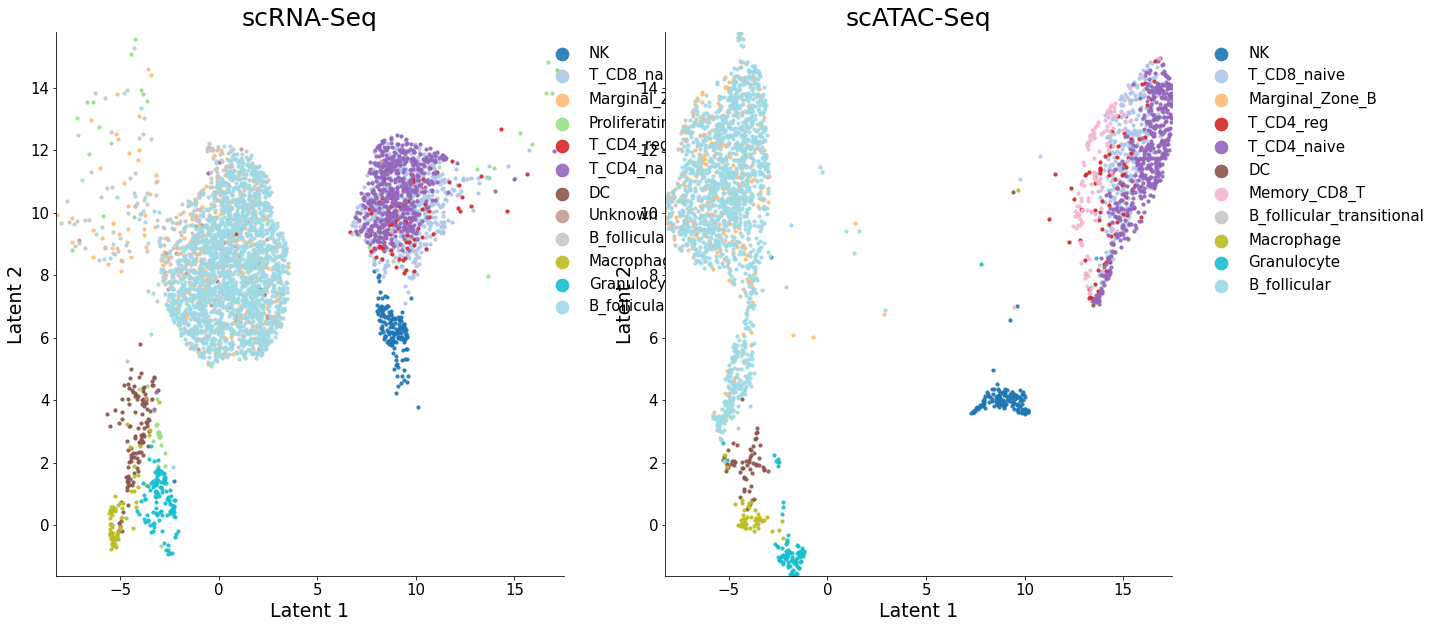

In [83]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

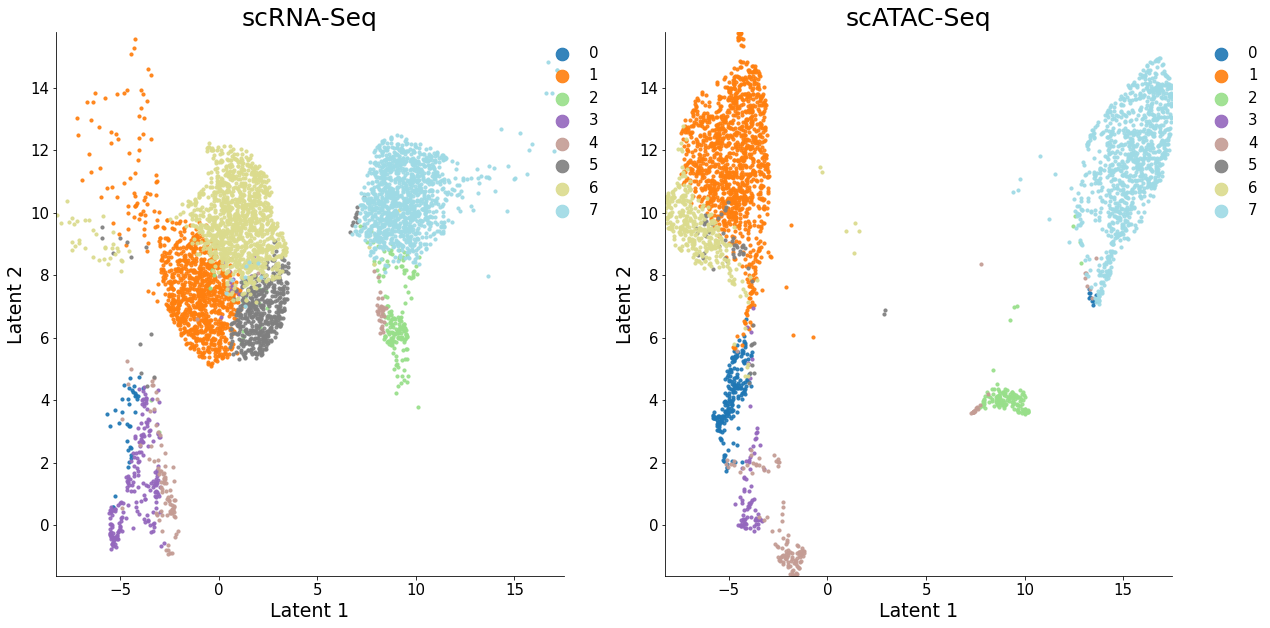

In [84]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

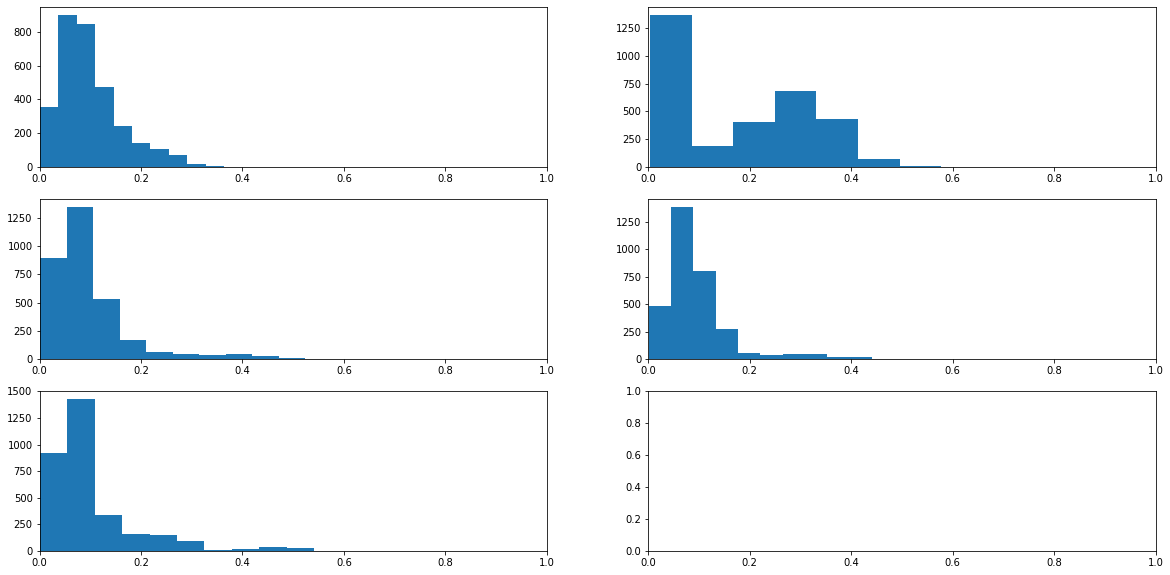

In [85]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_atac[:,0])
_ = axs[0,1].hist(z_atac[:,1])
_ = axs[1,0].hist(z_atac[:,2])
_ = axs[1,1].hist(z_atac[:,3])
_ = axs[2,0].hist(z_atac[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

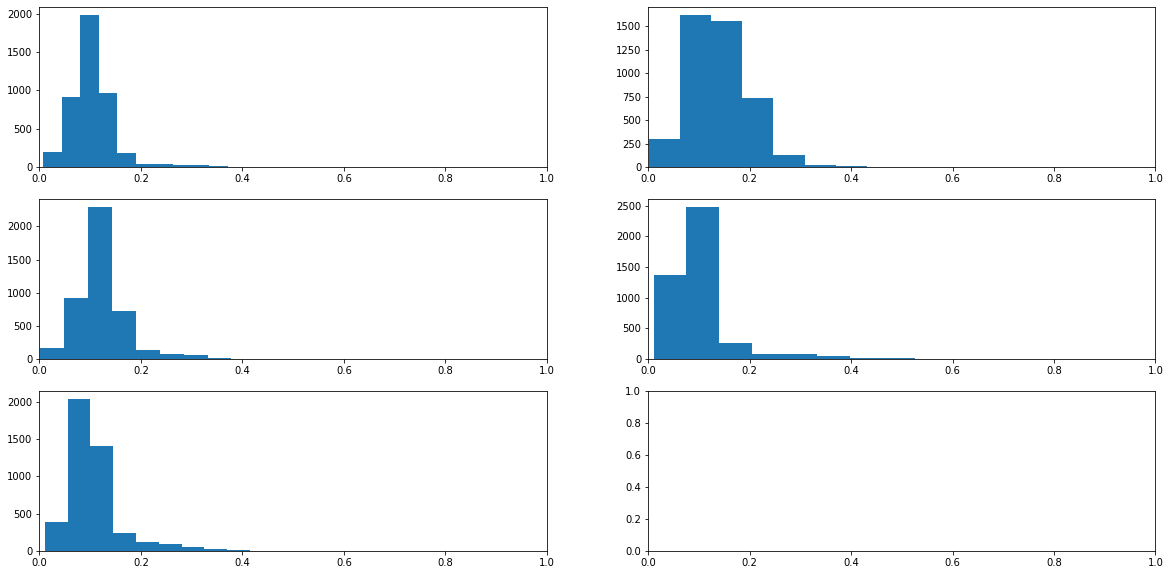

In [86]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_rna[:,0])
_ = axs[0,1].hist(z_rna[:,1])
_ = axs[1,0].hist(z_rna[:,2])
_ = axs[1,1].hist(z_rna[:,3])
_ = axs[2,0].hist(z_rna[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

/storage/home/hhive1/zzhang834/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


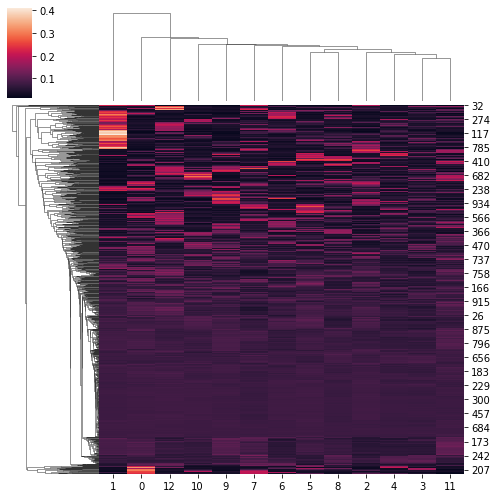

In [87]:
z_g = model1.softmax(model1.C_g).cpu().detach().numpy()
z_r = model1.softmax(model1.C_r).cpu().detach().numpy()
_ = sns.clustermap(z_g, figsize = (7,7))

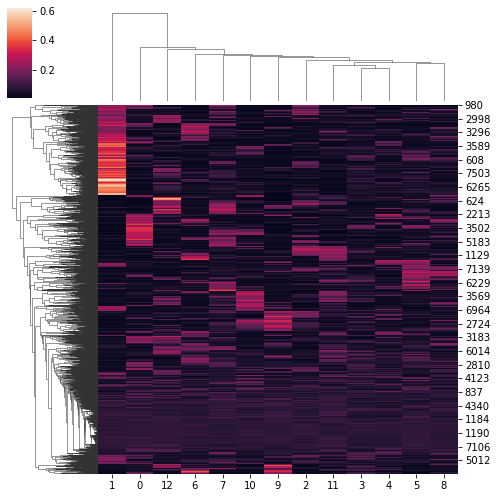

In [88]:
_ = sns.clustermap(z_r, figsize = (7,7))

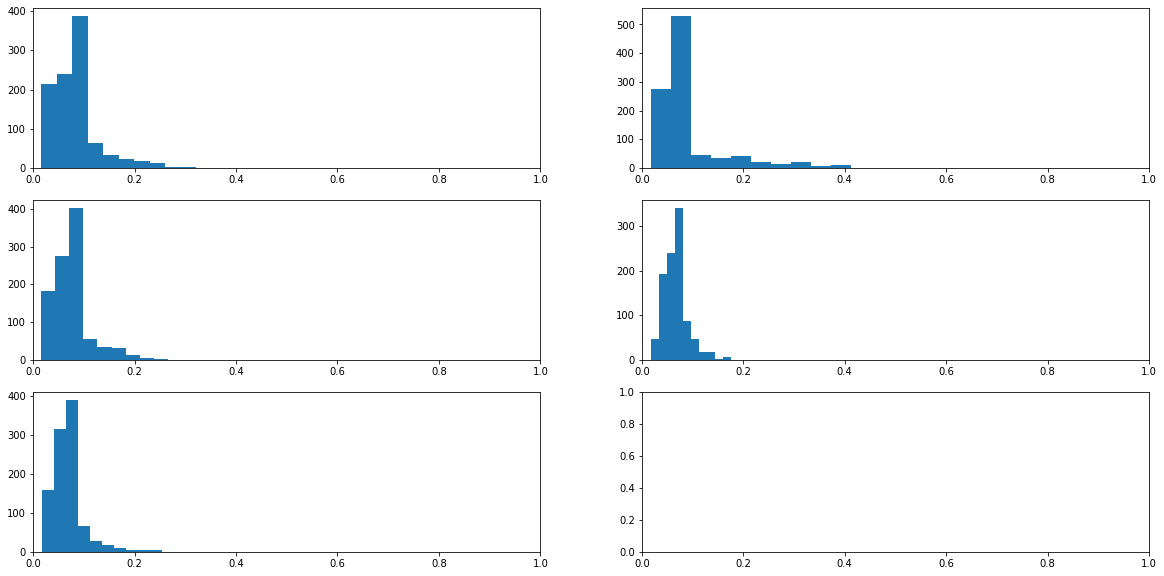

In [89]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_g[:,0])
_ = axs[0,1].hist(z_g[:,1])
_ = axs[1,0].hist(z_g[:,2])
_ = axs[1,1].hist(z_g[:,3])
_ = axs[2,0].hist(z_g[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

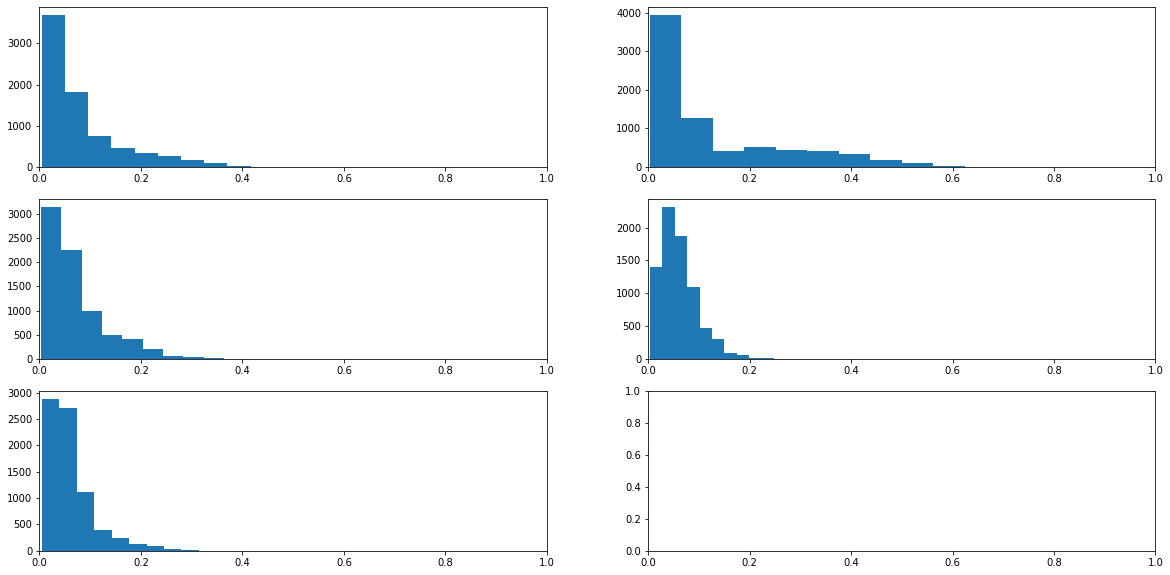

In [90]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_r[:,0])
_ = axs[0,1].hist(z_r[:,1])
_ = axs[1,0].hist(z_r[:,2])
_ = axs[1,1].hist(z_r[:,3])
_ = axs[2,0].hist(z_r[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

In [91]:
adjusted_rand_score(labels_pred = np.concatenate((max_rna, max_atac), axis = 0), labels_true = np.concatenate((label_rna, label_atac), axis = 0))

0.3059841747287431

# Equal gene cluster model

In [31]:
# train model
alpha = [1000, 1000, 100, 100, 1, 1, 1, 0]
model2 = diffmodel.cfrm_diff(counts, N1 = 5, N2 = 4, K = 4, batch_size = 0.3, interval=100, lr=1e-3, 
                            alpha =alpha, seed = 0, learn_gact = False).to(device)

model2.train_func(T = 10000)

Epoch 100, Validating Loss: -104.2260
	 loss 1: 34.65381
	 loss 2: 51.84988
	 loss 3: -93.89217
	 loss 4: -97.03128
	 loss 5: 0.19376
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4623262882232666
Epoch 200, Validating Loss: -110.7673
	 loss 1: 34.63398
	 loss 2: 51.80032
	 loss 3: -98.99874
	 loss 4: -98.39211
	 loss 5: 0.18921
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4607172012329102
Epoch 300, Validating Loss: -112.3415
	 loss 1: 34.59863
	 loss 2: 51.80844
	 loss 3: -99.86162
	 loss 4: -99.07124
	 loss 5: 0.18429
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.5279393196105957
Epoch 400, Validating Loss: -112.8486
	 loss 1: 34.60766
	 loss 2: 51.74386
	 loss 3: -99.98670
	 loss 4: -99.39233
	 loss 5: 0.17895
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.8207197189331055
Epoch 500, Validating Loss: -113.2336
	 loss 1: 34.58067
	 loss 2: 51.54408
	 loss 3: -99.99891
	 loss 4: -99.53232
	 loss 5: 0.

Epoch 4100, Validating Loss: -148.6615
	 loss 1: 20.56838
	 loss 2: 33.15482
	 loss 3: -99.99966
	 loss 4: -98.65907
	 loss 5: 0.03636
	 loss 6: -2.81085
	 loss 7: -0.95143
	 loss 8: 0.00000
Epoch 4200, Validating Loss: -148.7000
	 loss 1: 20.57157
	 loss 2: 33.15829
	 loss 3: -99.99969
	 loss 4: -98.69233
	 loss 5: 0.03473
	 loss 6: -2.82084
	 loss 7: -0.95179
	 loss 8: 0.00000
Epoch 4300, Validating Loss: -148.7577
	 loss 1: 20.55824
	 loss 2: 33.14814
	 loss 3: -99.99973
	 loss 4: -98.71548
	 loss 5: 0.03317
	 loss 6: -2.82964
	 loss 7: -0.95237
	 loss 8: 0.00000
Epoch 4400, Validating Loss: -148.7985
	 loss 1: 20.56316
	 loss 2: 33.13972
	 loss 3: -99.99970
	 loss 4: -98.74258
	 loss 5: 0.03170
	 loss 6: -2.83776
	 loss 7: -0.95298
	 loss 8: 0.00000
Epoch 4500, Validating Loss: -148.8466
	 loss 1: 20.55941
	 loss 2: 33.13691
	 loss 3: -99.99974
	 loss 4: -98.77451
	 loss 5: 0.03029
	 loss 6: -2.84521
	 loss 7: -0.95370
	 loss 8: 0.00000
Epoch 4600, Validating Loss: -148.8811
	 loss

Epoch 8400, Validating Loss: -150.1148
	 loss 1: 19.78869
	 loss 2: 33.10338
	 loss 3: -99.99939
	 loss 4: -99.08002
	 loss 5: 0.00725
	 loss 6: -2.92428
	 loss 7: -1.01043
	 loss 8: 0.00000
Epoch 8500, Validating Loss: -150.1434
	 loss 1: 19.76103
	 loss 2: 33.10636
	 loss 3: -99.99942
	 loss 4: -99.08182
	 loss 5: 0.00706
	 loss 6: -2.92468
	 loss 7: -1.01194
	 loss 8: 0.00000
Epoch 8600, Validating Loss: -150.1585
	 loss 1: 19.75135
	 loss 2: 33.10831
	 loss 3: -99.99940
	 loss 4: -99.08713
	 loss 5: 0.00688
	 loss 6: -2.92509
	 loss 7: -1.01339
	 loss 8: 0.00000
Epoch 8700, Validating Loss: -150.1751
	 loss 1: 19.73117
	 loss 2: 33.11259
	 loss 3: -99.99942
	 loss 4: -99.08587
	 loss 5: 0.00672
	 loss 6: -2.92554
	 loss 7: -1.01471
	 loss 8: 0.00000
Epoch 8800, Validating Loss: -150.2085
	 loss 1: 19.71557
	 loss 2: 33.10275
	 loss 3: -99.99944
	 loss 4: -99.09198
	 loss 5: 0.00655
	 loss 6: -2.92584
	 loss 7: -1.01613
	 loss 8: 0.00000
Epoch 8900, Validating Loss: -150.2388
	 loss

In [32]:
z_rna = model2.softmax(model2.C_1).cpu().detach().numpy()
z_atac = model2.softmax(model2.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

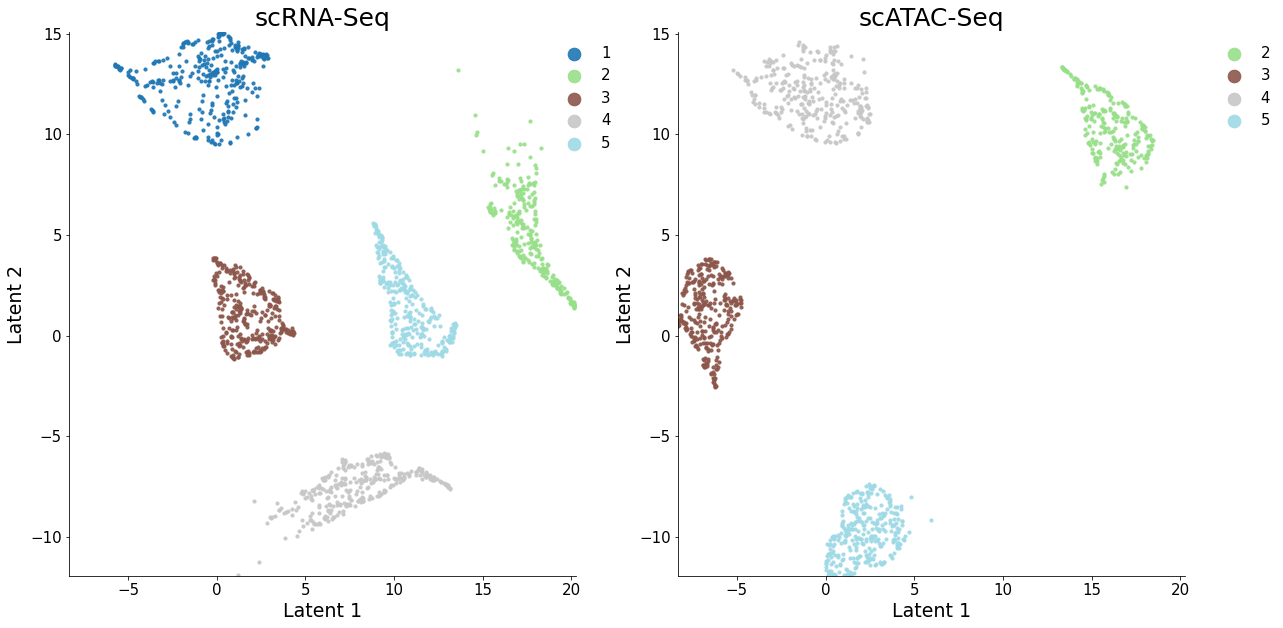

In [33]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

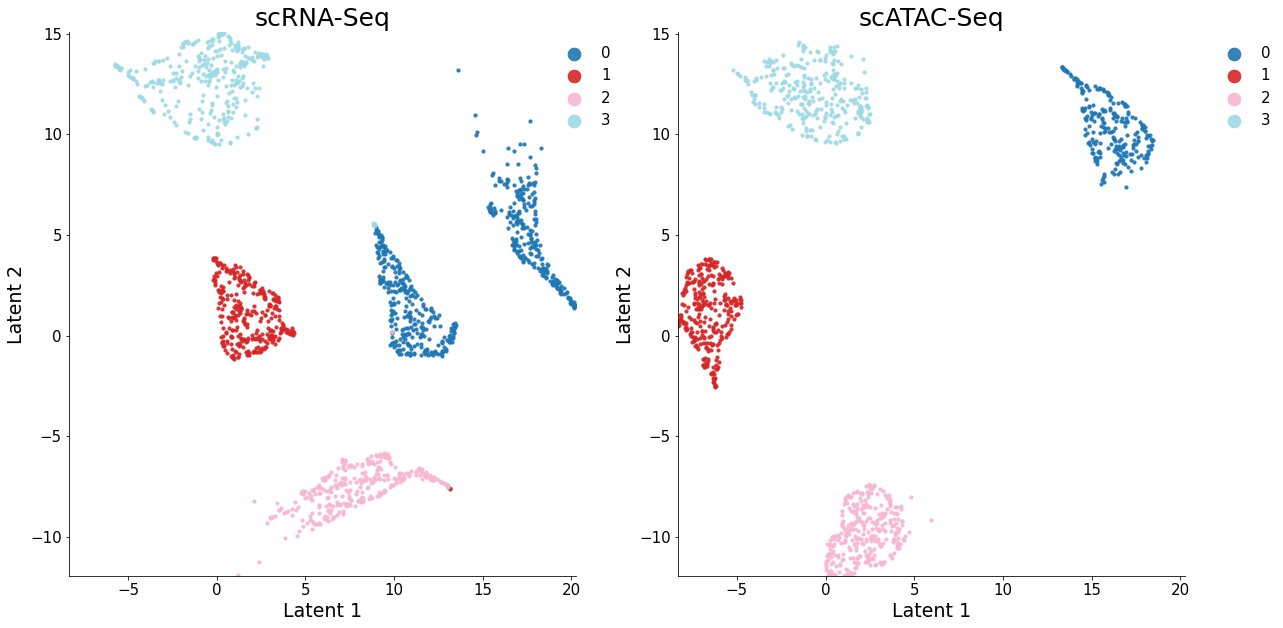

In [34]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

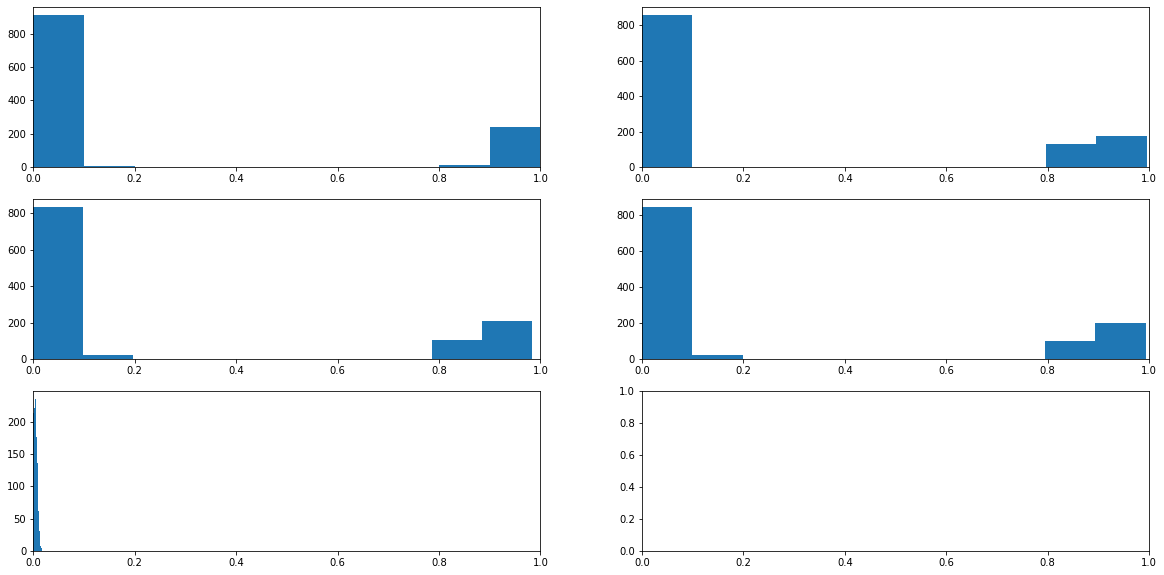

In [35]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_atac[:,0])
_ = axs[0,1].hist(z_atac[:,1])
_ = axs[1,0].hist(z_atac[:,2])
_ = axs[1,1].hist(z_atac[:,3])
_ = axs[2,0].hist(z_atac[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

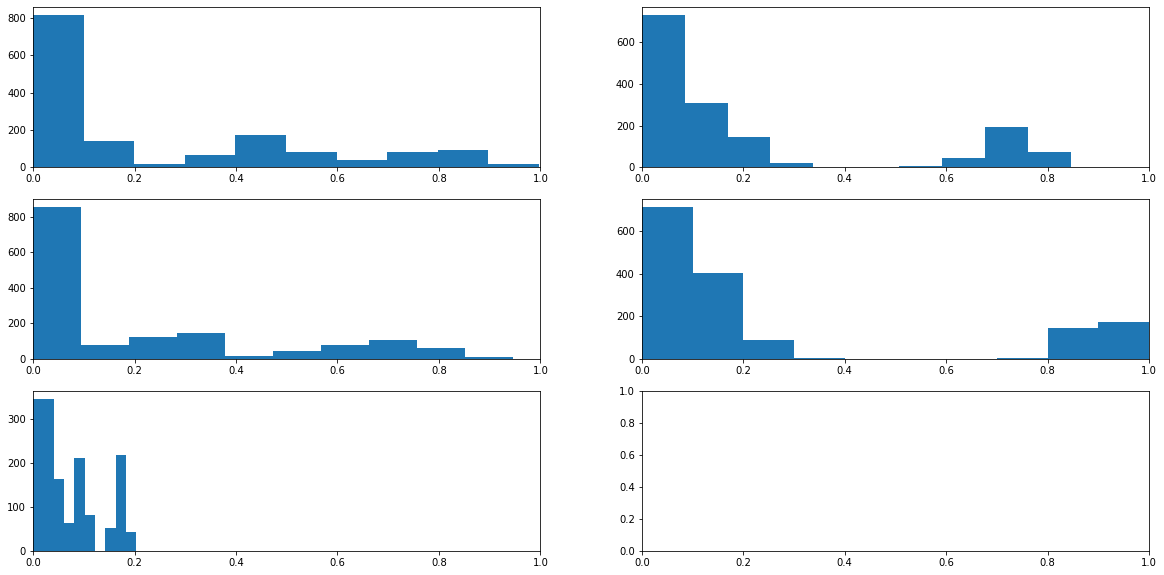

In [36]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_rna[:,0])
_ = axs[0,1].hist(z_rna[:,1])
_ = axs[1,0].hist(z_rna[:,2])
_ = axs[1,1].hist(z_rna[:,3])
_ = axs[2,0].hist(z_rna[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

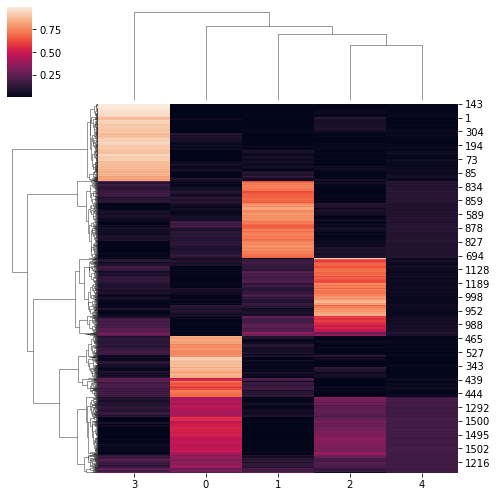

In [37]:
g = sns.clustermap(z_rna, figsize = (7,7))

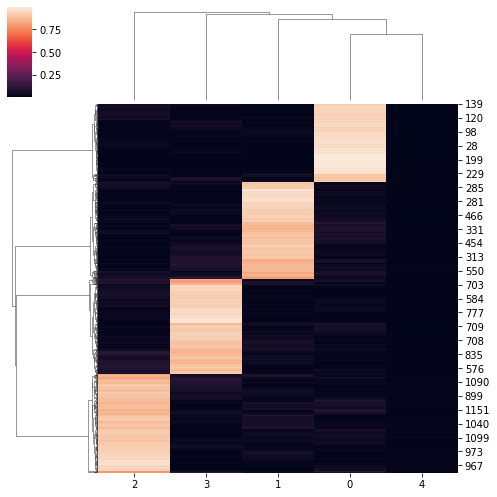

In [38]:
g = sns.clustermap(z_atac, figsize = (7,7))

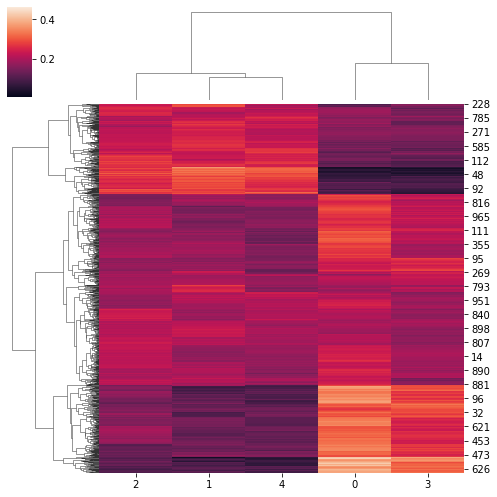

In [40]:
z_g = model2.softmax(model2.C_g).cpu().detach().numpy()
z_r = model2.softmax(model2.C_r).cpu().detach().numpy()
_ = sns.clustermap(z_g, figsize = (7,7))

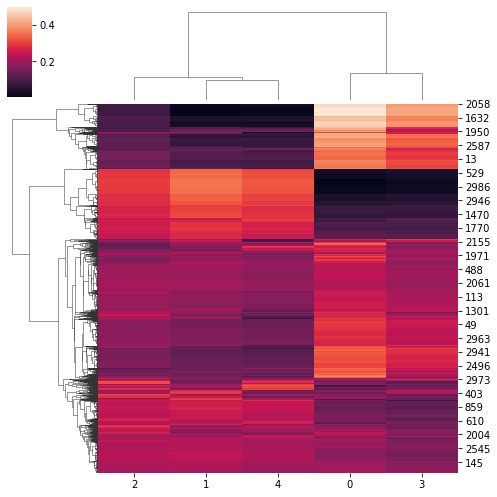

In [41]:
_ = sns.clustermap(z_r, figsize = (7,7))